### Necessary Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import math
import collections
import pandas as pd

### Loading the tweets dataset 
#### Please modify as per the location of the dataset.


In [2]:
geoTweets = pd.read_json('data/geoLondonJan', lines=True)

# 1. (i)

#### Defining function that calulates Haversine distance between 2 points 

In [3]:
def computeDistance(point1, point2):
    R = 6373.0

    lat1 = point1[1]
    long1 = point1[0]
    lat2 = point2[1]
    long2 = point2[0]

    phi1 = lat1 * (math.pi / 180)
    phi2 = lat2 * (math.pi / 180)

    delta1 = (lat2 - lat1) * (math.pi / 180)
    delta2 = (long2 - long1) * (math.pi / 180)

    a = math.sin(delta1 / 2) **2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta2 / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a) )
    d = R * c

    return d

    
print(computeDistance([-0.563, 51.261318], [0.28036, 51.686031]))

75.13724972074071


#### Defining function that accepts the  bouding coordinates and returns the partitioned grid coordinates (1km x 1km) 

In [4]:
def createGrid(point1, point2):
    
    bottomleft = point1
    bottomright = [point2[0], point1[1]]
    topleft = [point1[0], point2[1]]
    topright = point2
    
    #the distance is in km, thus number of rows/coloumns of grid = the distance between the points
    rows = int(np.ceil(computeDistance(bottomleft, topleft)))
    columns = int(np.ceil(computeDistance(bottomleft, bottomright)))
    
    noofGrids = int(rows * columns)
    colMax = int(np.ceil(computeDistance(bottomleft, bottomright)))
    
    rowPoints = []
    colPoints = []
    
    lonOffset = (point2[0] - point1[0]) / columns
    latOffset = (point2[1] - point1[1]) / rows

    for i in range(rows):
        rowPoints.append(51.261318 + i * latOffset)
        
    for j in range(columns):
        colPoints.append(-0.563 + j * lonOffset)
    
    return rowPoints, colPoints, lonOffset, latOffset

#accepting output as per the x and y axis points required to plot the tweets on grid
y, x, latOffset, lonOffset = createGrid([-0.563, 51.261318], [0.28036, 51.686031])

#### Calculating the centre points of the grids

In [5]:
xc = []
yc = []
for i in range(len(x)):
    xc.append(x[i] + latOffset/2)
for j in range(len(y)):
    yc.append(y[j] + lonOffset/2)

#### Storing the coordinates from the dataset (x-axis = longitude and y-axis = latitude)

In [6]:
xplot = []
yplot = []
for i in range(len(geoTweets)):
    xplot.append(geoTweets['coordinates'][i]['coordinates'][0])
    yplot.append(geoTweets['coordinates'][i]['coordinates'][1])

#### Calculating the counts of the tweets in each grid
##### The distance between the tweet coordinates and each grid centre is calculated. Tweet is assigned to the grid whose centre is the closest to the coordinates. 


In [7]:
tweet_count = np.zeros((len(x),len(y)), dtype='int')
grid_lat_list = []
grid_lon_list = []

for i in range(len(geoTweets)):
    point1 = [xplot[i], yplot[i]]
    min_d = 75
    lat_index = 0
    lon_index = 0
    for j in range(len(x)):
        for k in range(len(y)):
            point2 = [xc[j], yc[k]]
            d = computeDistance(point1, point2)
            if d<min_d :
                min_d = d
                lon_index = j
                lat_index = k
    
    grid_lat_list.append(lat_index)
    grid_lon_list.append(lon_index)
    tweet_count[lon_index,lat_index] +=1    

geoTweets['grid_lat'] = grid_lat_list
geoTweets['grid_lon'] = grid_lon_list

In [8]:
tweet_count = tweet_count.transpose()
tweet_count.shape

(48, 59)

#### Plotting a heatmap to visualize the distribution of the tweets within the grids
##### Data values are scaled using the LogNorm normalization because the distribution of the number of tweets in a single grid is across a very wide range (0 to 1349) and without norm the distribution is not effectively visualized. 

<ipython-input-9-a1caff2cb052>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(np.arange(len(x)), np.arange(len(y)), tweet_count, norm=colors.LogNorm())


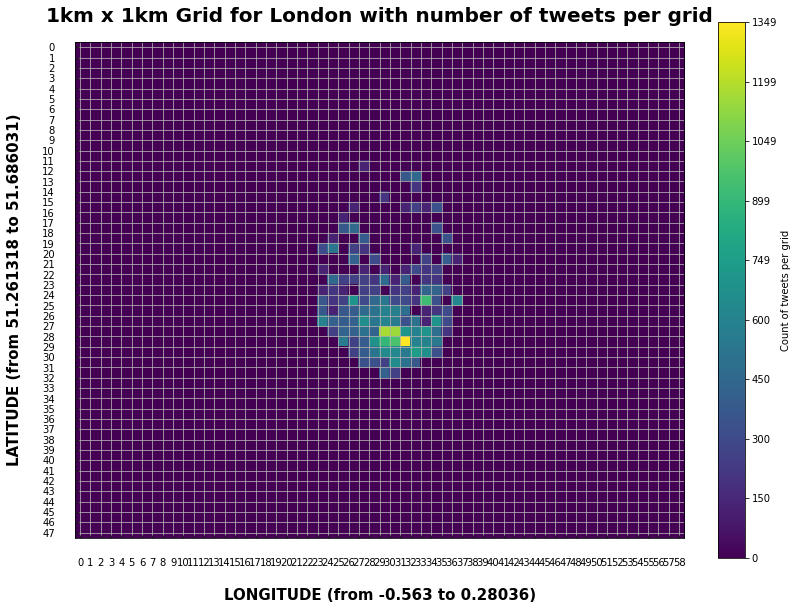

In [9]:
plt.rcParams["figure.figsize"] = [12.00, 12.00]
#plt.rcParams["figure.autolayout"] = True

ax1 = plt.subplot()
ax1.set_xticks(np.arange(len(x)))
ax1.set_yticks(np.arange(len(y)))
ax1.tick_params(axis="both", direction="in", pad=20)


ax1.pcolormesh(np.arange(len(x)), np.arange(len(y)), tweet_count, norm=colors.LogNorm())

ax1.figure.colorbar(ax1.imshow(tweet_count), label=('Count of tweets per grid'), 
                    ticks = np.linspace(tweet_count.min(), tweet_count.max(),10), fraction=0.040)

plt.xlabel('LONGITUDE (from -0.563 to 0.28036)', labelpad=20.0, fontsize=15, fontweight='bold')
plt.ylabel('LATITUDE (from 51.261318 to 51.686031)', labelpad=20.0, fontsize=15, fontweight='bold')
plt.title('1km x 1km Grid for London with number of tweets per grid', fontsize=20, fontweight='bold', pad=20.0)

plt.grid()
plt.show()

In [10]:
unique_dict = collections.Counter(sorted(tweet_count.ravel()))
unique = unique_dict.keys()
counts = unique_dict.values()

#### Please uncomment and run again to get the histogram on a Log scale for better visualization of distribution

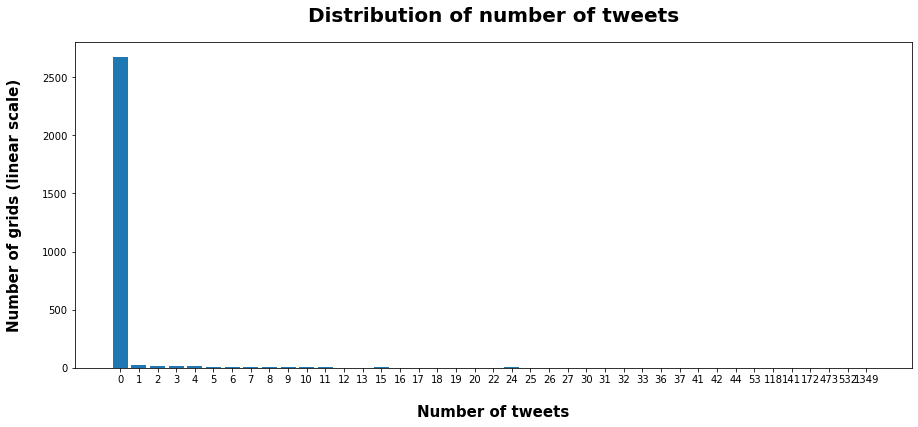

In [11]:
plt.figure(figsize=(15,6))
plt.xticks(range(len(unique)), unique)
plt.bar(range(len(unique)), counts)
#plt.bar(range(len(unique)), counts, log=True)
plt.title('Distribution of number of tweets', fontsize=20, fontweight='bold', pad=20.0)
plt.xlabel('Number of tweets', labelpad=20.0, fontsize=15, fontweight='semibold')
plt.ylabel('Number of grids (linear scale)', labelpad=20.0, fontsize=15, fontweight='semibold')
#plt.ylabel('Number of grids (Log scale)', labelpad=20.0, fontsize=15, fontweight='semibold')
plt.show()

# 1. (ii)

### Loading the high and low quality datasets 
#### Please modify as per the location of the dataset.

In [12]:
highfile = pd.read_json('data/highFileFeb', lines=True)
lowfile = pd.read_json('data/lowFileFeb', lines=True)

#### Importing spacy for tokenization of the tweet text

In [13]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

# Download a stopword list
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shauryabhagat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Stop word list is prepared which will all be removed while tokenization of the text

In [14]:
stop_words = set(stopwords.words('english'))

stop_words = stop_words.union(ENGLISH_STOP_WORDS)

nlp.Defaults.stop_words = stop_words.union(nlp.Defaults.stop_words)

#### Defining a fucntion that accepts a sentence of text and returns a list of tokenized words

In [15]:
def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
      if not t.is_stop and not t.is_punct and not t.is_space and t.is_alpha :
              tokens.append(t.lemma_.lower())
    return tokens

#### Building a high quality vocabulary using the high quality tweets dataset

In [16]:
hqvocab = []
for i in range(len(highfile)):
    listoftokens = text_pipeline_spacy(highfile['text'][i])
    for token in listoftokens:
        hqvocab.append(token)

/opt/anaconda3/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


#### Building a low quality vocabulary using the low quality tweets dataset

In [17]:
lqvocab = []
for i in range(len(highfile)):
    listoftokens = text_pipeline_spacy(lowfile['text'][i])
    for token in listoftokens:
        lqvocab.append(token)

#### Building a background vocabulary using the high and quality tweets datasets combined

In [18]:
bgvocab = sorted(hqvocab + lqvocab)

#### Using the collections.Counter function for calculating the term frequencies of each term in the high, low and background model

In [19]:
hq_counter = collections.Counter(hqvocab)
lq_counter = collections.Counter(lqvocab)
bg_counter = collections.Counter(bgvocab)

#### Building a scoring model for newsworthiness of the tweets and storing it as a dataframe

In [20]:
score = []

for key in bg_counter.keys():
    RHQ = (hq_counter[key]/len(hqvocab)) / (bg_counter[key]/len(bgvocab))
    RLQ = (lq_counter[key]/len(lqvocab)) / (bg_counter[key]/len(bgvocab))
    if(RHQ < 1.2):
        RHQ = 0
    if(RLQ < 1.2):
        RLQ = 0
    score.append([key, RHQ, RLQ])

In [21]:
score_df = pd.DataFrame(score, columns=['word','SHQ', 'SLQ'])
score_df = score_df.set_index('word')
score_df

,SHQ,SLQ
word,,
aampe,1.858691,0.000000
aaron,0.000000,2.164563
aaronism,0.000000,2.164563
abandoning,1.858691,0.000000
abba,1.394019,0.000000
...,...,...
𝑜𝑢𝑟,1.858691,0.000000
𝗚𝗘𝗧,1.858691,0.000000
𝗛𝗮𝗽𝘂𝘀,1.858691,0.000000


# 1. (iii)

#### Tokenizing the text in the given tweets dataset and storing it in a separate column of the same dataset

In [22]:
text_tokens = []
for i in range(len(geoTweets)):
    text_tokens.append(text_pipeline_spacy(geoTweets['text'][i]))
    
geoTweets['tokens'] = text_tokens

/opt/anaconda3/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


#### Using the previosly defined scoring model dataframe the tweets are scored as per the newsworthiness formula
##### The SHQ and SLQ scores of each token of the text are summed up and passed through a log function. The positive scored tweets are tagged as 1 (news-worthy) and negative scored tweets are tagged as 0 (not news-worthy) 

In [23]:
newsworthscore = []

for i in range(len(geoTweets)):
    SHQ_sum = 1
    SLQ_sum = 1
    
    for word in geoTweets['tokens'][i]:
        if(word in score_df.index.values):
            SHQ_sum += score_df['SHQ'][word]
            SLQ_sum += score_df['SLQ'][word]
            
    doc_score = math.log2(SHQ_sum/SLQ_sum)
    if(doc_score > 0):
        newsworthscore.append(1)
    else:
        newsworthscore.append(0)

geoTweets['NewsWorthy'] = newsworthscore

#### Based on the newsworthiness scores the results are visualized which depicts that nearly 75% of the given tweets data is not news worthy and only 25% is news worthy. 

In [24]:
worthysize = len(geoTweets[geoTweets['NewsWorthy'] == 1])
nonworthysize = len(geoTweets[geoTweets['NewsWorthy'] == 0])

News worthy count = 996
Not-News worthy count = 3146


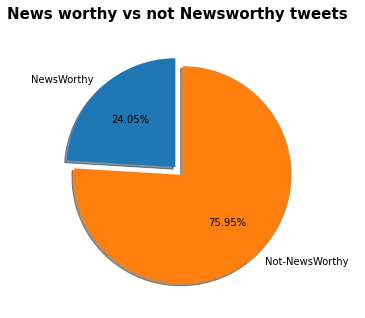

In [25]:
print('News worthy count =', worthysize)
print('Not-News worthy count =', nonworthysize)
plt.figure(figsize=(5,5))
plt.pie((worthysize, nonworthysize), labels = ['NewsWorthy', 'Not-NewsWorthy'], autopct='%1.2f%%', shadow=True, 
        startangle=90, explode=(0.1, 0))
plt.title('News worthy vs not Newsworthy tweets  ', fontsize=15, fontweight='bold', pad=20.0)
plt.show()

#### Calculating the counts of the newsworthy tweets in each grid

In [26]:
worthiness_count = np.zeros((len(x),len(y)))
not_worthy_count = np.zeros((len(x),len(y)))
for i in range(len(geoTweets)):
    if (geoTweets['NewsWorthy'][i] == 1) :
        worthiness_count[geoTweets['grid_lon'][i], geoTweets['grid_lat'][i]] +=1  
    else :
        not_worthy_count[geoTweets['grid_lon'][i], geoTweets['grid_lat'][i]] +=1  
    
worthiness_count = worthiness_count.transpose()    
not_worthy_count = not_worthy_count.transpose()    

#### Plotting a heatmap to visualize and compare the distribution of the newsworthy tweets with the previous heatmap


<ipython-input-27-5f07e2ee8194>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(np.arange(len(x)), np.arange(len(y)), worthiness_count, cmap='viridis', norm=colors.LogNorm())


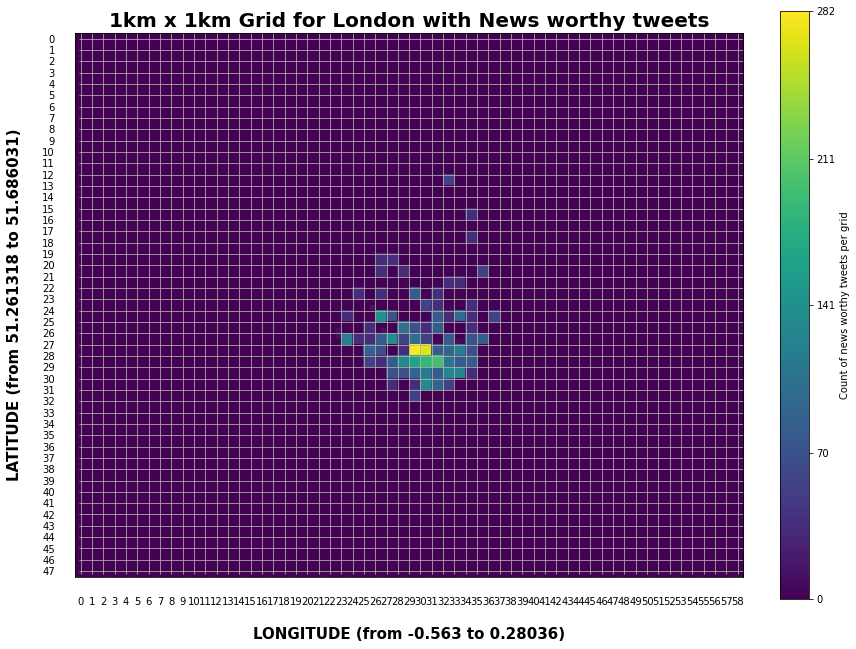

In [27]:
plt.rcParams["figure.figsize"] = [12.00, 12.00]
plt.rcParams["figure.autolayout"] = True

ax1 = plt.subplot()
ax1.set_xticks(np.arange(len(x)))
ax1.set_yticks(np.arange(len(y)))
ax1.tick_params(axis="both", direction="in", pad=20)


ax1.pcolormesh(np.arange(len(x)), np.arange(len(y)), worthiness_count, cmap='viridis', norm=colors.LogNorm())

ax1.figure.colorbar(ax1.imshow(worthiness_count), label=('Count of news worthy tweets per grid'), 
                    ticks = np.linspace(worthiness_count.min(), worthiness_count.max(),5, dtype=int), fraction=0.04)

plt.xlabel('LONGITUDE (from -0.563 to 0.28036)', labelpad=20.0, fontsize=15, fontweight='bold')
plt.ylabel('LATITUDE (from 51.261318 to 51.686031)', labelpad=20.0, fontsize=15, fontweight='bold')
plt.title('1km x 1km Grid for London with News worthy tweets', fontsize=20, fontweight='bold')

plt.grid()
plt.show()

In [28]:
unique_worthy_dict = collections.Counter(sorted(worthiness_count.ravel()))
unique_worthy = unique_worthy_dict.keys()
counts_worthy = unique_worthy_dict.values()

#### Please uncomment and run again to get the histogram on a Log scale for better visualization of distribution

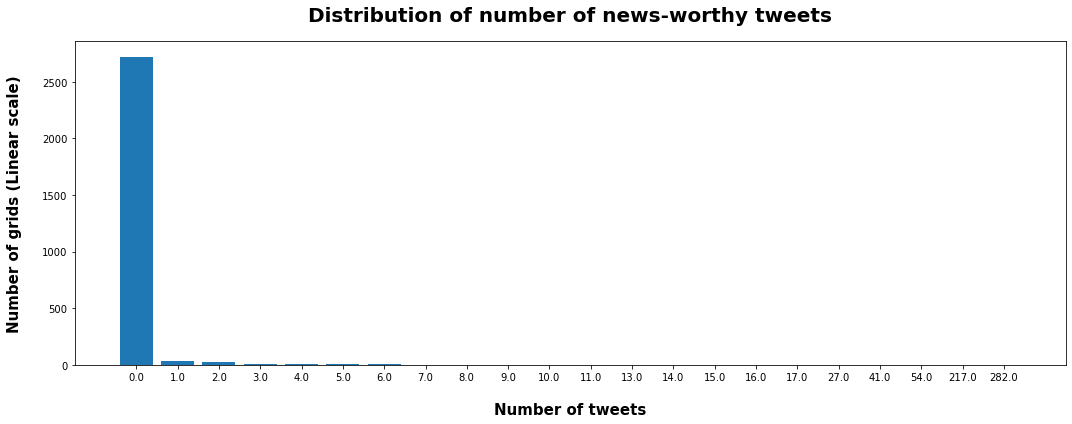

In [29]:
plt.figure(figsize=(15,6))
plt.xticks(range(len(unique_worthy)), unique_worthy)
plt.bar(range(len(unique_worthy)), counts_worthy)
#plt.bar(range(len(unique_worthy)), counts_worthy, log=True)
plt.title('Distribution of number of news-worthy tweets', fontsize=20, fontweight='bold', pad=20.0)
plt.xlabel('Number of tweets', labelpad=20.0, fontsize=15, fontweight='semibold')
plt.ylabel('Number of grids (Linear scale)', labelpad=20.0, fontsize=15, fontweight='semibold')
#plt.ylabel('Number of grids (Log scale)', labelpad=20.0, fontsize=15, fontweight='semibold')

plt.show()

#### Creating separate dataframes having news worthy and non-newsworthy tweets

In [30]:
newsWorthyTweets = geoTweets[geoTweets['NewsWorthy'] == 1]
nonnewsWorthyTweets = geoTweets[geoTweets['NewsWorthy'] == 0]